# Load and View Data

Number of data points: 200
k in [0, 199]


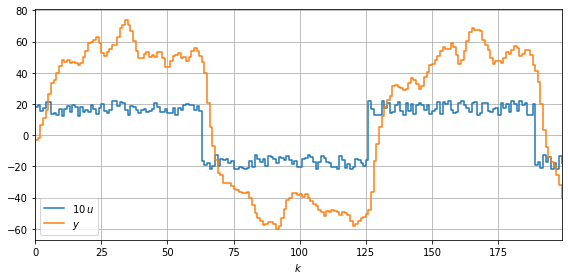

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

file = '../data.csv'
data = pd.read_csv(file, header=None, names=['u', 'y'])
N = len(data)

k = data.index.values
u = data.u.values
y = data.y.values

print('Number of data points:', N)
print(f'k in [{k[0]}, {k[-1]}]')

plt.figure(figsize=(8,4))
plt.plot(k, 10*u, label='$10\,u$', drawstyle='steps-post')
plt.plot(k, y   , label='$y$'    , drawstyle='steps-post')
plt.xlim(k[0], k[-1])
plt.xlabel('$k$')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

## Input Fourier Transform

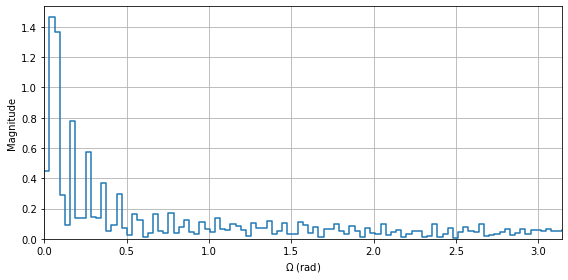

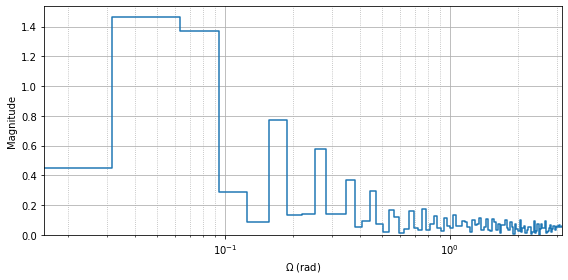

In [2]:
from scipy import fft

u_rfft = fft.rfft(u, norm='forward')
u_rfft[1:-1] = 2*u_rfft[1:-1]

u_rfft_mag = np.abs(u_rfft)
Omega = np.linspace(0, np.pi, len(u_rfft_mag))

plt.figure(figsize=(8,4))
plt.plot(Omega, u_rfft_mag, drawstyle='steps-post')
plt.xlim(Omega[0], Omega[-1])
plt.ylim(0)
plt.xlabel('$\\Omega$ (rad)')
plt.ylabel('Magnitude')
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(Omega, u_rfft_mag, drawstyle='steps-post')
plt.xscale('log')
plt.xlim(Omega[1]/2, Omega[-1])
plt.ylim(0)
plt.xlabel('$\\Omega$ (rad)')
plt.ylabel('Magnitude')
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.tight_layout()
plt.show()

## Separate Identification and Validation Data

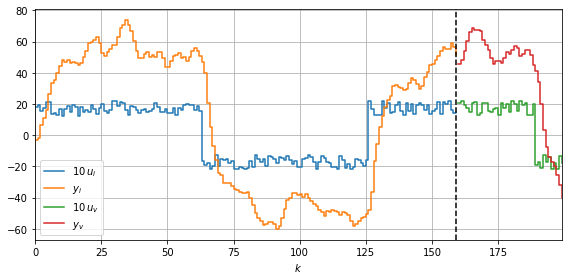

In [52]:
N_fold = 160

k_i = k[:N_fold]
u_i = u[:N_fold]
y_i = y[:N_fold]

k_v = k[N_fold:]
u_v = u[N_fold:]
y_v = y[N_fold:]

plt.figure(figsize=(8,4))
plt.plot(k_i, 10*u_i, label='$10\,u_i$', drawstyle='steps-post')
plt.plot(k_i, y_i   , label='$y_i$'    , drawstyle='steps-post')
plt.plot(k_v, 10*u_v, label='$10\,u_v$', drawstyle='steps-post')
plt.plot(k_v, y_v   , label='$y_v$'    , drawstyle='steps-post')
plt.axvline(k[N_fold-1], color='black', linestyle='--')
plt.xlim(k[0], k[-1])
plt.xlabel('$k$')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

# Generic Model

\begin{gather*}
A(q) \, y[k] = \dfrac{B(q)}{F(q)} \, u[k] + \dfrac{C(q)}{D(q)} \, e[k]
\\
y[k] = G(q) \, u[k] + H(q) \, e[k]
\\
G(q) = \dfrac{B(q)}{A(q) \, F(q)}
\qquad
H(q) = \dfrac{C(q)}{A(q) \, D(q)}
\\
A(q) = 1 + a_1 \, q^{-1} + \dotsb + a_{n_a} \, q^{-n_a}
\\
B(q) = q^{-n_k} \, \left(b_0 + b_1 \, q^{-1} + \dotsb + b_{n_b} \, q^{-n_b}\right)
\\
C(q) = 1 + c_1 \, q^{-1} + \dotsb + c_{n_c} \, q^{-n_c}
\\
D(q) = 1 + d_1 \, q^{-1} + \dotsb + d_{n_d} \, q^{-n_d}
\\
F(q) = 1 + f_1 \, q^{-1} + \dotsb + f_{n_f} \, q^{-n_f}
\end{gather*}

## Prediction Error Method

\begin{gather*}
\hat{y}[k] = L_u(q) \, u[k] + L_y(q) \, y[k]
\\
L_u(q) = \dfrac{G(q)}{H(q)}
\\
L_y(q) = 1 - \dfrac{1}{H(q)}
\end{gather*}

## Prediction Cost

\begin{gather*}
  \hat{J} = \dfrac{1}{N} \sum_{k=1}^N \left(y[k] - \hat{y}[k]\right)^2
\end{gather*}

# ARX

\begin{gather*}
y[k] = G(q) \, u[k] + H(q) \, e[k]
\\
G(q) = \dfrac{B(q)}{A(q)}
\qquad
H(q) = \dfrac{1}{A(q)}
\\
A(q) = 1 + a_1 \, q^{-1} + \dotsb + a_{n_a} \, q^{-n_a}
\\
B(q) = q^{-n_k} \, \left(b_0 + b_1 \, q^{-1} + \dotsb + b_{n_b} \, q^{-n_b}\right)
\end{gather*}

\begin{gather*}
n_a = \{0, 1, 2, 3\}
\qquad
n_b = \{0, 1, 2\}
\qquad
n_k = \{1, 2, 3\}
\end{gather*}

In [4]:
from functions import arx

na_range = range(0, 3 + 1)
nb_range = range(0, 2 + 1)
nk_range = range(1, 3 + 1)

models_arx = arx(u_i, y_i, u_v, y_v, na_range, nb_range, nk_range)

## Display Best 

In [5]:
from functions import display_models

display_models(models_arx.sort_values(by=['Jv']), columns=['na', 'nb', 'nk', 'Jv', 'Ji', 'A', 'B'], precision=4, qty=10)

,na,nb,nk,Jv,Ji,A,B
0,3,1,1,5.5558,5.7396,[ 1. -1.3524 0.5032 -0.0458],[0. 2.1432 0.8729]
0,2,2,1,5.5889,5.2762,[ 1. -1.4068 0.4826],[ 0. 2.1625 1.6108 -1.6016]
0,3,2,1,5.6340,5.2750,[ 1. -1.3995 0.4627 0.0122],[ 0. 2.1558 1.6239 -1.6225]
0,2,1,1,5.8008,5.7504,[ 1. -1.3097 0.4174],[0. 2.1418 0.9413]
0,3,0,1,6.0739,5.8750,[ 1. -1.4147 0.5565 -0.051 ],[0. 2.6055]
0,2,0,1,6.3842,5.9102,[ 1. -1.3708 0.4638],[0. 2.6559]
0,3,0,2,7.4904,6.9459,[ 1. -1.3873 0.4881 -0.0085],[0. 0. 2.5496]
0,2,0,2,7.6454,6.9680,[ 1. -1.366 0.4622],[0. 0. 2.6626]
0,2,1,2,7.8900,6.5159,[ 1. -1.4641 0.5285],[ 0. 0. 3.2668 -1.5127]
0,3,1,2,8.0226,6.4955,[ 1. -1.4339 0.4481 0.0488],[ 0. 0. 3.2988 -1.5975]


# ARMAX

\begin{gather*}
y[k] = G(q) \, u[k] + H(q) \, e[k]
\\
G(q) = \dfrac{B(q)}{A(q)}
\qquad
H(q) = \dfrac{C(q)}{A(q)}
\\
A(q) = 1 + a_1 \, q^{-1} + \dotsb + a_{n_a} \, q^{-n_a}
\\
B(q) = q^{-n_k} \, \left(b_0 + b_1 \, q^{-1} + \dotsb + b_{n_b} \, q^{-n_b}\right)
\\
C(q) = 1 + c_1 \, q^{-1} + \dotsb + c_{n_c} \, q^{-n_c}
\end{gather*}

\begin{gather*}
n_a = \{0, 1, 2, 3\}
\qquad
n_b = \{0, 1, 2\}
\qquad
n_c = \{1, 2, 3\}
\qquad
n_k = \{1, 2, 3\}
\end{gather*}

In [6]:
from functions import armax

na_range = range(0, 3 + 1)
nb_range = range(0, 2 + 1)
nc_range = range(1, 3 + 1)
nk_range = range(1, 3 + 1)

models_armax = armax(u_i, y_i, u_v, y_v, na_range, nb_range, nc_range, nk_range)

## Display Best 

In [7]:
from functions import display_models

display_models(models_armax.sort_values(by=['Jv']), columns=['na', 'nb', 'nc', 'nk', 'Jv', 'Ji', 'A', 'B', 'C'], precision=4, qty=10)

,na,nb,nc,nk,Jv,Ji,A,B,C
0,2,2,1,1,5.5785,5.2770,[ 1. -1.3952 0.4728],[ 0. 2.1016 1.7255 -1.6017],[1. 0.0216]
0,3,1,1,1,5.8139,5.4788,[ 1. -0.7403 -0.3703 0.272 ],[0. 1.8562 2.7502],[1. 0.5879]
0,3,2,1,1,5.8322,5.2604,[ 1. -1.2479 0.2488 0.0891],[ 0. 2.0695 2.0321 -1.5339],[1. 0.1593]
0,3,0,1,1,5.8525,5.8018,[ 1. -1.5819 0.8218 -0.1578],[0. 2.3682],[ 1. -0.1876]
0,1,2,1,1,6.0209,5.9025,[ 1. -0.84],[ 0. 2.239 2.843 -0.3675],[1. 0.4336]
0,2,1,1,1,6.2367,5.6517,[ 1. -1.1588 0.2881],[0. 1.9753 1.7543],[1. 0.2029]
0,2,0,1,1,6.2438,5.9050,[ 1. -1.3996 0.4888],[0. 2.537],[ 1. -0.0399]
0,2,0,2,1,7.3064,5.8321,[ 1. -1.3664 0.4606],[0. 2.6759],[ 1. -0.0062 0.1153]
0,3,0,2,1,7.8192,5.5410,[ 1. -1.5948 0.9398 -0.2549],[0. 2.6218],[ 1. -0.2164 0.2494]
0,1,1,1,1,7.9668,5.8985,[ 1. -0.8326],[0. 2.1322 2.7844],[1. 0.437]


# Output Error

\begin{gather*}
y[k] = G(q) \, u[k] + H(q) \, e[k]
\\
G(q) = \dfrac{B(q)}{F(q)}
\qquad
H(q) = 1
\\
B(q) = q^{-n_k} \, \left(b_0 + b_1 \, q^{-1} + \dotsb + b_{n_b} \, q^{-n_b}\right)
\\
F(q) = 1 + f_1 \, q^{-1} + \dotsb + f_{n_f} \, q^{-n_f}
\end{gather*}

\begin{gather*}
n_b = \{0, 1, 2\}
\qquad
n_f = \{1, 2, 3\}
\qquad
n_k = \{1, 2, 3\}
\end{gather*}

In [8]:
from functions import oe

nb_range = range(0, 2 + 1)
nf_range = range(1, 3 + 1) # nf = 0 causa erro no pysid!
nk_range = range(1, 3 + 1)

models_oe = oe(u_i, y_i, u_v, y_v, nb_range, nf_range, nk_range)

## Display Best 

In [9]:
from functions import display_models

display_models(models_oe.sort_values(by=['Jv']), columns=['nb', 'nf', 'nk', 'Jv', 'Ji', 'B', 'F',], precision=4, qty=10)

,nb,nf,nk,Jv,Ji,B,F
0,2,2,2,167.7475,49.5503,[ 0. 0. 7.7118 -6.9075 0.2866],[ 1. -1.5244 0.5601]
0,2,3,2,167.9192,49.4864,[ 0. 0. 7.978 -3.2287 -3.063 ],[ 1. -0.9518 -0.3204 0.3272]
0,2,2,3,175.2363,67.8214,[ 0. 0. 0. 10.2879 -9.6789 0.9381],[ 1. -1.4015 0.4531]
0,2,3,3,175.2679,67.7220,[ 0. 0. 0. 10.5427 -5.0892 -3.0755],[ 1. -0.8704 -0.2848 0.2346]
0,1,3,1,181.5961,45.0879,[ 0. 3.3507 -2.7665],[ 1. -2.1778 1.6256 -0.429 ]
0,2,2,1,184.1463,45.6277,[ 0. 3.5064 -0.0782 -2.6062],[ 1. -1.6008 0.6273]
0,2,1,2,187.4925,51.5602,[ 0. 0. 8.083 -1.7842 -2.4118],[ 1. -0.871]
0,2,1,3,187.6696,69.0736,[ 0. 0. 0. 10.6192 -4.0831 -2.7328],[ 1. -0.872]
0,1,2,2,193.4881,50.2382,[ 0. 0. 7.5631 -6.4238],[ 1. -1.5097 0.5469]
0,1,3,2,194.3558,50.1724,[ 0. 0. 7.8384 -6.694 ],[ 1. -1.4545 0.4468 0.045 ]


# Box-Jenkins

\begin{gather*}
y[k] = G(q) \, u[k] + H(q) \, e[k]
\\
G(q) = \dfrac{B(q)}{F(q)}
\qquad
H(q) = \dfrac{C(q)}{D(q)}
\\
B(q) = q^{-n_k} \, \left(b_0 + b_1 \, q^{-1} + \dotsb + b_{n_b} \, q^{-n_b}\right)
\\
C(q) = 1 + c_1 \, q^{-1} + \dotsb + c_{n_c} \, q^{-n_c}
\\
D(q) = 1 + d_1 \, q^{-1} + \dotsb + d_{n_d} \, q^{-n_d}
\\
F(q) = 1 + f_1 \, q^{-1} + \dotsb + f_{n_f} \, q^{-n_f}
\end{gather*}

\begin{gather*}
n_b = \{0, 1, 2\}
\qquad
n_c = \{0, 1, 2, 3\}
\qquad
n_d = \{0, 1, 2, 3\}
\qquad
n_f = \{0, 1, 2, 3\}
\qquad
n_k = \{1, 2, 3\}
\end{gather*}

In [ ]:
from functions import bj # diversos erros

nb_range = range(0, 2 + 1)
nc_range = range(0, 3 + 1)
nd_range = range(0, 3 + 1)
nf_range = range(0, 3 + 1)
nk_range = range(1, 3 + 1)

models_bj = bj(u_i, y_i, u_v, y_v, nb_range, nc_range, nd_range, nf_range, nk_range)

## Display Best 

In [11]:
from functions import display_models

display_models(models_bj.sort_values(by=['Jv']), columns=['nb', 'nc', 'nd', 'nf', 'nk', 'Jv', 'Ji', 'B', 'C', 'D', 'F'], precision=4, qty=10)

,nb,nc,nd,nf,nk,Jv,Ji,B,C,D,F
0,2,0,2,3,1,5.4871,5.2137,[ 0. 2.0629 2.5924 -0.6554],[1.],[ 1. -1.4404 0.5514],[ 1. -0.9704 0.0724 0.0341]
0,2,0,2,2,1,5.5212,5.2144,[0. 2.0782 3.2191 0.2747],[1.],[ 1. -1.4398 0.5513],[ 1. -0.6716 -0.139 ]
0,2,0,2,1,1,5.5239,5.2144,[ 0. 2.0827 2.8744 -0.1977],[1.],[ 1. -1.4396 0.5513],[ 1. -0.8382]
0,1,0,3,1,1,5.6826,5.193,[0. 2.039 2.8255],[1.],[ 1. -1.4025 0.4521 0.0692],[ 1. -0.8346]
0,2,0,3,3,1,5.6935,5.139,[ 0. 2.0368 2.5593 -0.6899],[1.],[ 1. -1.4028 0.4495 0.072 ],[ 1. -0.9766 0.0658 0.0435]
0,2,0,3,1,1,5.721,5.1395,[ 0. 2.0651 2.8472 -0.1961],[1.],[ 1. -1.4031 0.4531 0.0692],[ 1. -0.84]
0,2,0,3,2,1,5.7254,5.1394,[0. 2.0595 3.266 0.3694],[1.],[ 1. -1.4029 0.4519 0.0701],[ 1. -0.6367 -0.1701]
0,1,0,3,3,1,5.8495,5.1903,[0. 2.0456 3.023 ],[1.],[ 1. -1.4025 0.4502 0.0713],[ 1. -0.7514 -0.1005 0.024 ]
0,1,0,3,2,1,5.8949,5.1916,[0. 2.0645 3.002 ],[1.],[ 1. -1.4031 0.4527 0.0696],[ 1. -0.7657 -0.0624]
0,1,0,2,1,1,5.9411,5.1828,[0. 2.0522 2.8633],[1.],[ 1. -1.4391 0.5502],[ 1. -0.8325]


# Compare Results

In [12]:
from functions import models_frame

models = pd.concat([models_frame(), models_arx, models_armax, models_oe, models_bj], ignore_index=True)
models.sort_values(by=['Jv'], inplace=True)

print('Successful models:', len(models.loc[models.B.notnull()]))
print('Failed models:    ', len(models.loc[models.B.isnull()]))

Successful models: 531
Failed models:     216


## Display Models with Lowest Cost

In [26]:
from functions import display_models
from control import frequency_response, mag2db

qty = 20

display_models(models, columns=['model', 'na', 'nb', 'nc', 'nd', 'nf', 'nk', 'Jv', 'Ji'], precision=4, qty=qty)

,model,na,nb,nc,nd,nf,nk,Jv,Ji
588,BJ,-,2,0,2,3,1,5.4871,5.2137
585,BJ,-,2,0,2,2,1,5.5212,5.2144
582,BJ,-,2,0,2,1,1,5.5239,5.2144
30,ARX,3,1,-,-,-,1,5.5558,5.7396
108,ARMAX,2,2,1,-,-,1,5.5785,5.277
24,ARX,2,2,-,-,-,1,5.5889,5.2762
33,ARX,3,2,-,-,-,1,5.634,5.275
402,BJ,-,1,0,3,1,1,5.6826,5.193
600,BJ,-,2,0,3,3,1,5.6935,5.139
594,BJ,-,2,0,3,1,1,5.721,5.1395


## Frequency Response

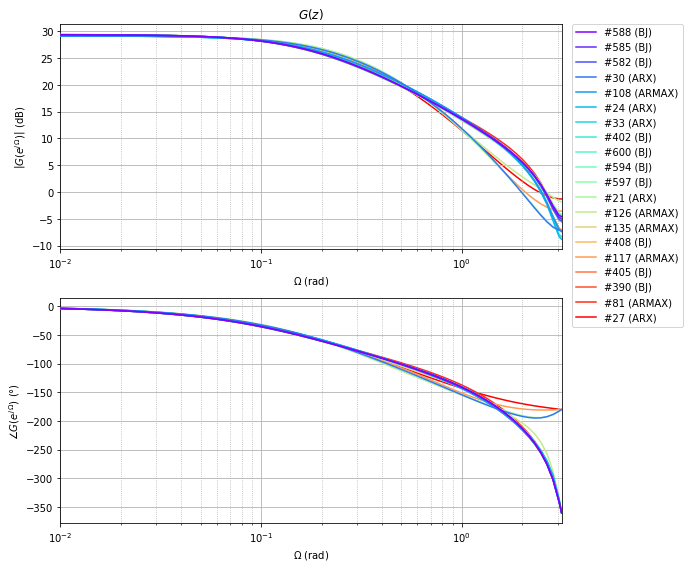

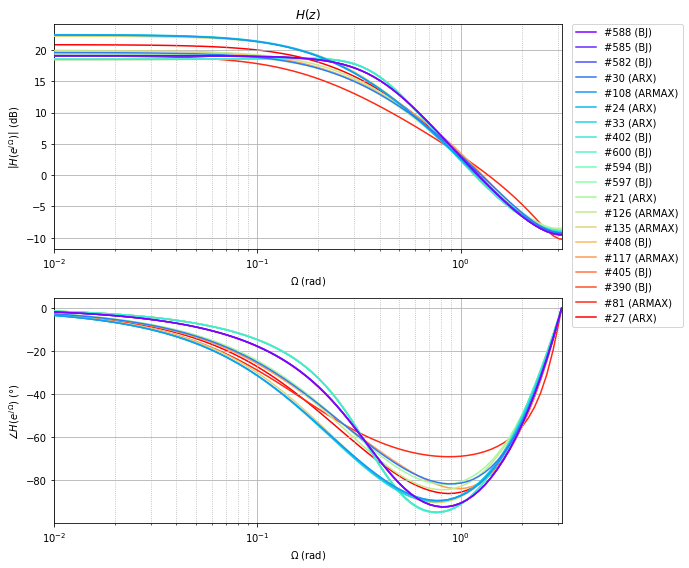

In [27]:
logspace = np.logspace(-2, 1, 100)
logspace = np.append(logspace[logspace < np.pi], np.pi)

for tf in ['G', 'H']:
  fig, axs = plt.subplots(2, 1, figsize=(8,8))
  colors = iter(plt.cm.rainbow(np.linspace(0, 1, qty)))
  for i, (index, model) in enumerate(models.iterrows()):
    if i >= qty:
      break
    color = next(colors)
    mag, phase, omega = frequency_response(model[tf], omega=logspace)
    axs[0].plot(omega, mag2db(mag), c=color, zorder=qty-i)
    axs[1].plot(omega, 180/np.pi*np.unwrap(phase), c=color, zorder=qty-i, label=f"#{index} ({model.model})")

  for ax in axs:
    ax.set_xscale('log')
    ax.set_xlim(omega[0], omega[-1])
    ax.grid(which='major')
    ax.grid(which='minor', linestyle=':')
    ax.set_xlabel('$\\Omega$ (rad)')
  axs[0].set_title(f'${tf}(z)$')
  axs[0].set_ylabel(f'$\\left| {tf}\\left(e^{{j \\, \\Omega}}\\right) \\right|$ (dB)')
  axs[1].set_ylabel(f'$\\angle{{{tf}\\left(e^{{j \\, \\Omega}}\\right)}}$ (°)')
  fig.legend(bbox_to_anchor=(1.2, 0.96))
  plt.tight_layout()
  plt.show()

## Pole Zero Map

In [24]:
# models.loc[len(models.pG) == 1]

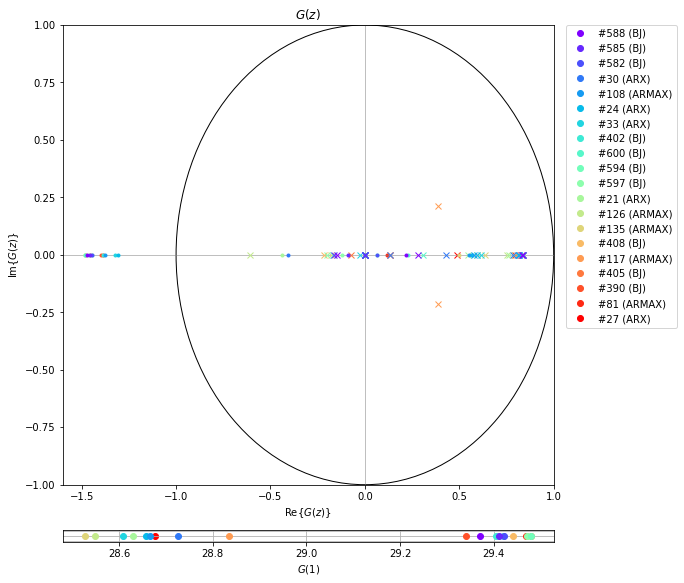

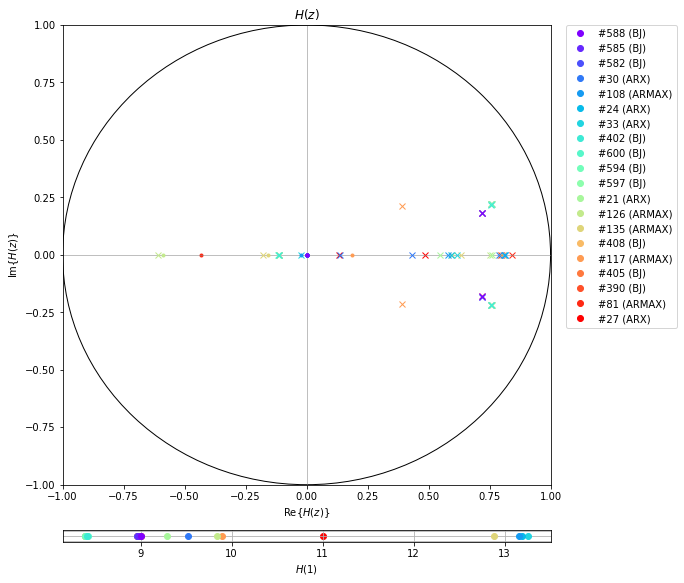

In [29]:
for tf in ['G', 'H']:
  fig, ax = plt.subplots(2, 1, figsize=(8,8.2), height_ratios=[8, 0.2])
  colors = iter(plt.cm.rainbow(np.linspace(0, 1, qty)))
  for i, (index, model) in enumerate(models.iterrows()):
    if i >= qty:
      break
    color = next(colors)
    for pole in model[f'p{tf}']:
      ax[0].plot(pole.real, pole.imag, 'x', c=color, zorder=qty-i)
    for zero in model[f'z{tf}']:
      ax[0].plot(zero.real, zero.imag, '.', c=color, zorder=qty-i)
    ax[1].plot(model[f'k{tf}'], 0, 'o', c=color, zorder=qty-i, label=f"#{index} ({model.model})")

  ax[0].set_title(f'${tf}(z)$')
  ax[1].set_xlabel(f'${tf}(1)$')
  ax[0].add_artist(plt.Circle((0, 0), 1, fill=False))
  ax[0].set_xlabel(f'$\\mathrm{{Re}}\\{{{tf}(z)\\}}$')
  ax[0].set_ylabel(f'$\\mathrm{{Im}}\\{{{tf}(z)\\}}$')
  xlim = ax[0].get_xlim()
  ylim = ax[0].get_ylim()
  ax[0].set_xlim(min(xlim[0], -1), max(xlim[1], 1))
  ax[0].set_ylim(min(ylim[0], -1), max(ylim[1], 1))
  ax[0].axhline(0, color='gray', linewidth=0.5)
  ax[0].axvline(0, color='gray', linewidth=0.5)
  ax[1].tick_params(axis='y',left=False, labelleft=False)
  ax[1].grid()
  fig.legend(bbox_to_anchor=(1.19, 0.96))
  plt.tight_layout()
  plt.show()

## Static Gains Scatter

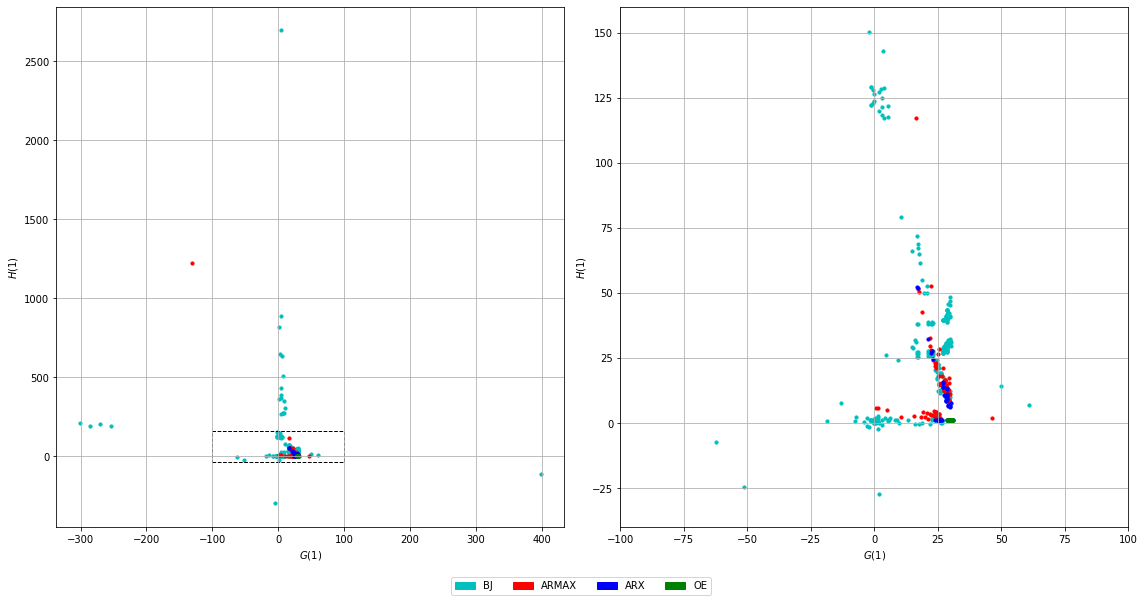

In [40]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots(1, 2, figsize=(16,8))

for i in range(0, 1+1):
  ax[i].scatter(models.loc[models.model == 'BJ'].kG,    models.loc[models.model == 'BJ'].kH,    s=10, color='c')
  ax[i].scatter(models.loc[models.model == 'ARMAX'].kG, models.loc[models.model == 'ARMAX'].kH, s=10, color='r')
  ax[i].scatter(models.loc[models.model == 'ARX'].kG,   models.loc[models.model == 'ARX'].kH,   s=10, color='b')
  ax[i].scatter(models.loc[models.model == 'OE'].kG,    models.loc[models.model == 'OE'].kH,    s=10, color='g')
  ax[i].set_xlabel('$G(1)$')
  ax[i].set_ylabel('$H(1)$')
  ax[i].grid()

ax[0].add_patch(plt.Rectangle((-100,-40), 200, 200, fill=False, linestyle='--'))

ax[1].set_xlim((-100, 100))
ax[1].set_ylim((-40, 160))

fig.legend(ncols=4, bbox_to_anchor=(0.625, 0), handles=[
  mpatches.Patch(color='c', label='BJ'),
  mpatches.Patch(color='r', label='ARMAX'),
  mpatches.Patch(color='b', label='ARX'),
  mpatches.Patch(color='g', label='OE'),
])
plt.tight_layout()
plt.show()

## Predictions with Lowest Cost

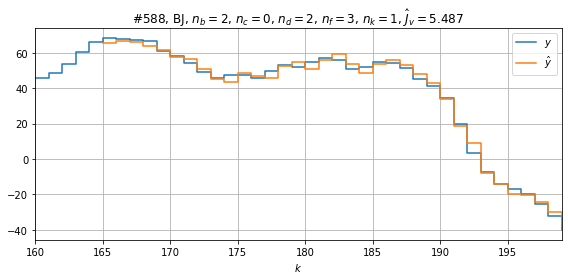

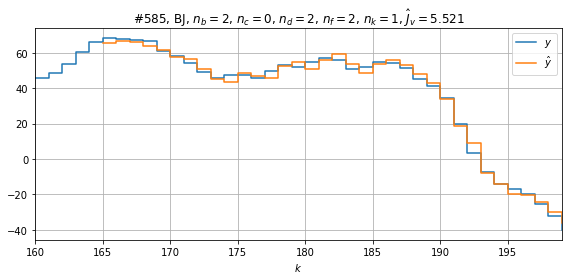

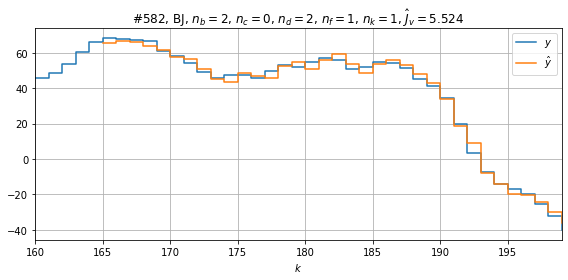

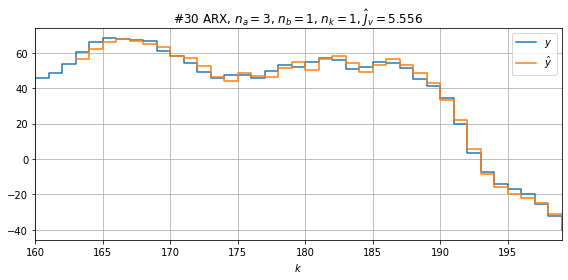

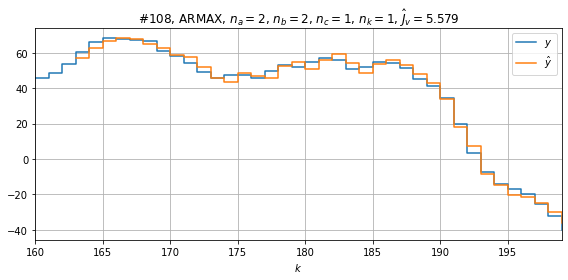

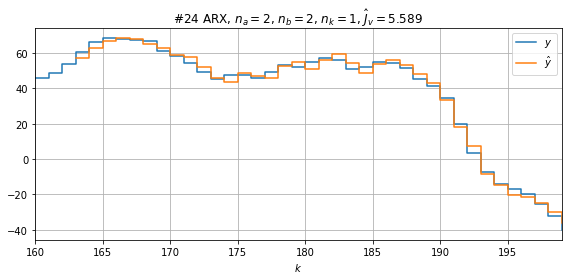

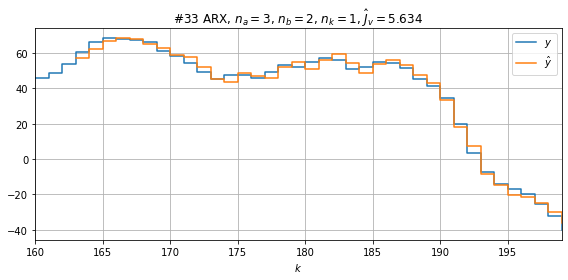

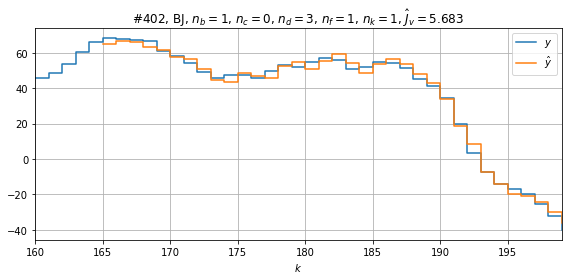

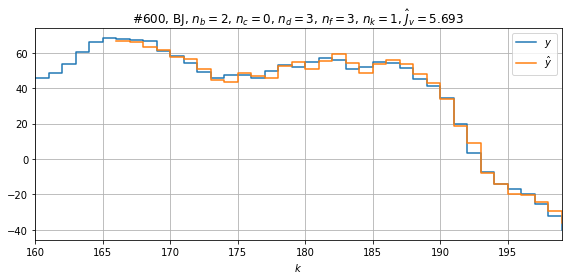

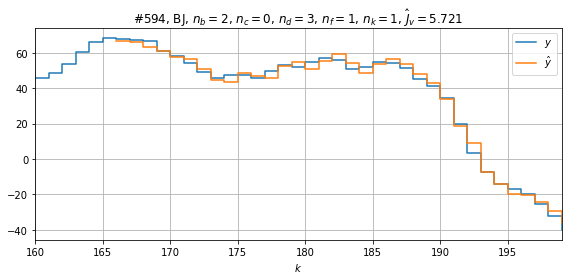

In [47]:
qty = 10
for i, (index, model) in enumerate(models.iterrows()):
  if i >= qty:
    break

  if np.isnan(model.yp).any():
    continue

  if model.model == 'ARX':
    title = f'#{index} {model.model}, $n_a={model.na}$, $n_b={model.nb}$, $n_k={model.nk}$, $\hat{{J}}_v={model.Jv:.4g}$'
  elif model.model == 'ARMAX':
    title = f'#{index}, {model.model}, $n_a={model.na}$, $n_b={model.nb}$, $n_c={model.nc}$, $n_k={model.nk}$, $\hat{{J}}_v={model.Jv:.4g}$'
  elif model.model == 'OE':
    title = f'#{index}, {model.model}, $n_b={model.nb}$, $n_f={model.nf}$, $n_k={model.nk}$, $\hat{{J}}_v={model.Jv:.4g}$'
  elif model.model == 'BJ':
    title = f'#{index}, {model.model}, $n_b={model.nb}$, $n_c={model.nc}$, $n_d={model.nd}$, $n_f={model.nf}$, $n_k={model.nk}$, $\hat{{J}}_v={model.Jv:.4g}$'
  else:
    assert(False)

  plt.figure(figsize=(8,4))
  plt.title(title)
  plt.plot(k_v, y_v, label='$y$', drawstyle='steps-post')
  plt.plot(k_v[int(model.delay):], model.yp, label='$\\hat{y}$', drawstyle='steps-post')
  plt.xlim(k_v[0], k_v[-1])
  plt.xlabel('$k$')
  plt.grid()
  plt.legend()
  plt.tight_layout()
  plt.show()

# Model in Class

G =


TransferFunction(array([ 2.16246556,  1.61084338, -1.6016382 ]), array([ 1.        , -1.40683412,  0.48261202,  0.        ]), True)

H =


TransferFunction(array([1., 0., 0.]), array([ 1.        , -1.40683412,  0.48261202]), True)

J_v = 5.588946926532913
J_i = 5.276219485889688


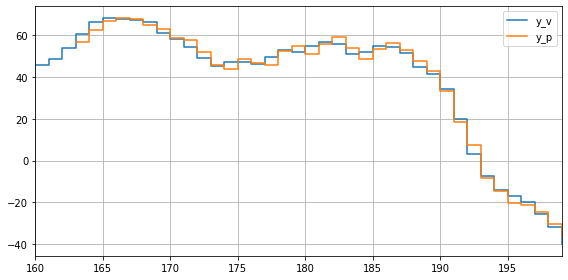

In [18]:
model = models.loc[(models.model == 'ARX') & (models.na == 2) & (models.nb == 2) & (models.nk == 1)]
assert(len(model) == 1)
model = model.iloc[0]

print('G =')
display(model.G)
print('H =')
display(model.H)
print('J_v =', model.Jv)
print('J_i =', model.Ji)

plt.figure(figsize=(8,4))
plt.plot(k_v, y_v, label='y_v', drawstyle='steps-post')
plt.plot(k_v[int(model.delay):], model.yp, label='y_p', drawstyle='steps-post')
plt.xlim(k_v[0], k_v[-1])
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

## Compare to Original System

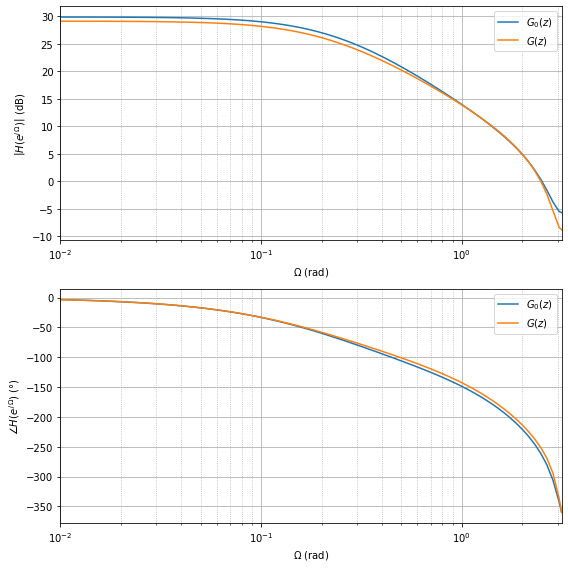

In [19]:
from control import TransferFunction, frequency_response, mag2db

G0 = TransferFunction([2, 2, -1.5], [1, -1.4, 0.48, 0], dt=True)

logspace = np.logspace(-2, 1, 100)
logspace = np.append(logspace[logspace < np.pi], np.pi)

mag,  phase,  omega  = frequency_response(model.G, omega=logspace)
mag0, phase0, omega0 = frequency_response(G0,      omega=logspace)

fig, axs = plt.subplots(2, 1, figsize=(8,8))
axs[0].plot(omega0, mag2db(mag0), label = '$G_0(z)$')
axs[1].plot(omega0, 180/np.pi*np.unwrap(phase0), label = '$G_0(z)$')
axs[0].plot(omega,  mag2db(mag), label = '$G(z)$')
axs[1].plot(omega,  180/np.pi*np.unwrap(phase), label = '$G(z)$')
for ax in axs:
  ax.set_xscale('log')
  ax.set_xlim(omega[0], omega[-1])
  ax.grid(which='major')
  ax.grid(which='minor', linestyle=':')
  ax.legend()
  ax.set_xlabel('$\\Omega$ (rad)')
  axs[0].set_ylabel(f'$\\left| {tf}\\left(e^{{j \\, \\Omega}}\\right) \\right|$ (dB)')
  axs[1].set_ylabel(f'$\\angle{{{tf}\\left(e^{{j \\, \\Omega}}\\right)}}$ (°)')
plt.tight_layout()
plt.show()